# Hydro generation profile for WECC and Texas
### Bainan Xia 08/22/2019

In [19]:
import pandas as pd

# CA hydro v2

## Get hourly net demand profile based on western demand v4

In [20]:
from powersimdata.scenario.scenario import Scenario
from powersimdata.input.grid import Grid

In [21]:
s9 = Scenario("9")
wind = s9.state.get_wind()
solar = s9.state.get_solar()
demand = s9.state.get_demand()
hydro = s9.state.get_hydro()
western = Grid(['Western'])
plant = western.plant

SCENARIO: test_scaling | base_2016

--> State
analyze
--> Loading ct
--> Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line
--> Loading wind
--> Loading solar
--> Loading demand
--> Loading hydro
--> Loading Western interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line


In [22]:
wind_plant_id_list = []
for plantid in wind.columns:
    if plant.loc[plantid]['zone_name'] in {'Northern California','Bay Area','Central California','Southwest California','Southeast California'}:
        wind_plant_id_list.append(plantid)
solar_plant_id_list = []
for plantid in solar.columns:
    if plant.loc[plantid]['zone_name'] in {'Northern California','Bay Area','Central California','Southwest California','Southeast California'}:
        solar_plant_id_list.append(plantid)

In [23]:
windsum = wind[wind_plant_id_list].sum(axis = 1)
solarsum = solar[solar_plant_id_list].sum(axis = 1)
# CA here
demandsum = demands = demand[[203,204,205,206,207]].sum(axis = 1)
netdemand = [demandsum[i] - windsum[i] - solarsum[i] for i in demandsum.index]

## Get monthly total net generation from EIA923

In [24]:
filename = 'EIA923_Schedules_2_3_4_5_M_12_2016_Final_Revision.xlsx'
filedir = './f923_2016/'
plant_generation = pd.read_excel(io = filedir + filename, header = 0, usecols = 'A,D,G,I,P,CB:CM',skiprows = range(5))
# Filter by state and fuel type, HYC: conventional; hydro HPS: pump hydro
net_generation_by_plant = plant_generation[(plant_generation['Plant State'] == 'CA') & ((plant_generation['AER\nFuel Type Code'] == 'HYC')|(plant_generation['AER\nFuel Type Code'] == 'HPS'))].copy()
# Drop unnecessary columns, plant ID, etc..
net_generation = net_generation_by_plant.drop(net_generation_by_plant.columns[[0,1,2,3,4]], axis=1)
# Get monthly total net generation by summing up across plants with all positive values, note that negative ones are included in actual demand
EIA_net_generation = list(net_generation.apply(lambda x: x[x>0].sum()).values)

## Scale hourly net demand profile based on EIA monthly total net genration

In [25]:
days_per_month = [31,29,31,30,31,30,31,31,30,31,30,31]
hour_num = [day*24 for day in days_per_month]
hour_month_mapping = []
month_factor = [0]*12
hour_count = 0
for i,hour in enumerate(hour_num):
    hour_month_mapping += [i]*hour
    net_demand_sum = sum(netdemand[hour_count:hour_count+hour])
    hour_count += hour
    month_factor[i] = EIA_net_generation[i]/net_demand_sum
hydro_v2_ca_total = [nd*month_factor[hour_month_mapping[i]] for i, nd in enumerate(netdemand)] 

## Decompose total hydro profile v2 into plant level profile based on hydro generator capacities

In [26]:
hydro_plant_id_list = []
total_hydro_capacity = 0
for plantid in hydro.columns:
    if plant.loc[plantid]['zone_name'] in {'Northern California','Bay Area','Central California','Southwest California','Southeast California'}:
        hydro_plant_id_list.append(plantid)
        total_hydro_capacity += plant.loc[plantid]['GenMWMax']

In [27]:
hydro_v2 = pd.DataFrame(index = hydro.index, columns = hydro.columns)
cnt = 0
for plantid in hydro_plant_id_list:
    print(cnt,plantid)
    factor = plant.loc[plantid]['GenMWMax']/total_hydro_capacity
    plant_profile = [val*factor for val in hydro_v2_ca_total]
    hydro_v2[plantid] = plant_profile.copy()
    cnt += 1

0 10816
1 10817
2 10820
3 10830
4 10831
5 10832
6 10833
7 10834
8 10835
9 10836
10 10837
11 10838
12 10839
13 10840
14 10841
15 10842
16 10843
17 10846
18 10847
19 10848
20 10849
21 10853
22 10854
23 10855
24 10856
25 10857
26 10861
27 10862
28 10863
29 10864
30 10868
31 10869
32 10870
33 10873
34 10874
35 10875
36 10876
37 10877
38 10878
39 10879
40 10880
41 10881
42 10882
43 10883
44 10884
45 10885
46 10886
47 10887
48 10888
49 10889
50 10890
51 10891
52 10892
53 10893
54 10894
55 10895
56 10896
57 10897
58 10898
59 10899
60 10900
61 10901
62 10902
63 10905
64 10906
65 10907
66 10908
67 10909
68 10910
69 10911
70 10912
71 10913
72 10914
73 10915
74 10916
75 10926
76 10927
77 10928
78 10929
79 10930
80 10931
81 10932
82 10933
83 10934
84 10942
85 10945
86 10946
87 10947
88 10954
89 10961
90 10962
91 10963
92 10964
93 10971
94 10972
95 10983
96 10984
97 10993
98 10994
99 10995
100 10996
101 10997
102 11000
103 11001
104 11002
105 11003
106 11004
107 11017
108 11018
109 11019
110 11020


# WA hydro v2

## Get hourly profile for top 20 dams from CoreArmy database

In [28]:
filename = 'hydro_gmt.csv'
filedir = './'
aggregate_hourly_profile_wa_nw = pd.read_csv(filedir+filename,header = 0,index_col = 'DateTimeUTC')
aggregate_hourly_profile_wa_nw = list(aggregate_hourly_profile_wa_nw.dropna()['sum_hydro'])

## Get monthly total net generation from EIA923

In [29]:
net_generation_by_plant = plant_generation[(plant_generation['Plant State'] == 'WA') & ((plant_generation['AER\nFuel Type Code'] == 'HYC')|(plant_generation['AER\nFuel Type Code'] == 'HPS'))].copy()
# Drop unnecessary columns, plant ID, etc..
net_generation = net_generation_by_plant.drop(net_generation_by_plant.columns[[0,1,2,3,4]], axis=1)
# Get monthly total net generation by summing up across plants with all positive values, note that negative ones are included in actual demand
EIA_net_generation = list(net_generation.apply(lambda x: x[x>0].sum()).values)

## Scale top 20 dams hourly profile based on EIA monthly total net genration

In [30]:
hour_count = 0
for i,hour in enumerate(hour_num):
    month_sum = sum(aggregate_hourly_profile_wa_nw[hour_count:hour_count+hour])
    hour_count += hour
    month_factor[i] = EIA_net_generation[i]/month_sum
hydro_v2_wa_total = [val*month_factor[hour_month_mapping[i]] for i, val in enumerate(aggregate_hourly_profile_wa_nw)] 

In [31]:
sum(EIA_net_generation)

78348006.0

In [32]:
sum(aggregate_hourly_profile_wa_nw)

91352862.30999981

## Decompose total hydro profile v2 into plant level profile based on hydro generator capacities

In [33]:
hydro_plant_id_list = []
total_hydro_capacity = 0
for plantid in hydro.columns:
    if plant.loc[plantid]['zone_name'] in {'Washington'}:
        hydro_plant_id_list.append(plantid)
        total_hydro_capacity += plant.loc[plantid]['GenMWMax']

In [34]:
cnt = 0
for plantid in hydro_plant_id_list:
    print(cnt,plantid)
    factor = plant.loc[plantid]['GenMWMax']/total_hydro_capacity
    plant_profile = [val*factor for val in hydro_v2_wa_total]
    hydro_v2[plantid] = plant_profile.copy()
    cnt += 1

0 10390
1 10391
2 10392
3 10393
4 10394
5 10395
6 10396
7 10398
8 10399
9 10402
10 10403
11 10404
12 10405
13 10406
14 10407
15 10408
16 10409
17 10410
18 10411
19 10412
20 10413
21 10414
22 10415
23 10416
24 10417
25 10418
26 10419
27 10420
28 10421
29 10422
30 10425
31 10426
32 10427
33 10429
34 10430
35 10431
36 10432
37 10433
38 10434
39 10435
40 10436
41 10437
42 10438
43 10439
44 10440
45 10443
46 10444
47 10445
48 10446
49 10449
50 10450
51 10464
52 10465
53 10466
54 10467
55 10468
56 10469
57 10471
58 10472
59 10476
60 10477
61 10478
62 10479
63 10480
64 10481
65 10485
66 10486
67 10487
68 10488
69 10489
70 10490
71 10491
72 10492
73 10493
74 10494
75 10495
76 10496
77 10499
78 10500
79 10501
80 10502
81 10503
82 10504
83 10506
84 10507
85 10508
86 10509
87 10510
88 10511
89 10512
90 10513
91 10520
92 10521
93 10523
94 10524
95 10525
96 10526
97 10527
98 10528
99 10529
100 10530
101 10531
102 10532
103 10533
104 10536
105 10537
106 10542
107 10543
108 10547
109 10548
110 10549


# The rest of states in WECC hydro v2

## OR

In [35]:
net_generation_by_plant = plant_generation[(plant_generation['Plant State'] == 'OR') & ((plant_generation['AER\nFuel Type Code'] == 'HYC')|(plant_generation['AER\nFuel Type Code'] == 'HPS'))].copy()
# Drop unnecessary columns, plant ID, etc..
net_generation = net_generation_by_plant.drop(net_generation_by_plant.columns[[0,1,2,3,4]], axis=1)
# Get monthly total net generation by summing up across plants with all positive values, note that negative ones are included in actual demand
EIA_net_generation = list(net_generation.apply(lambda x: x[x>0].sum()).values)

In [36]:
hour_count = 0
for i,hour in enumerate(hour_num):
    month_sum = sum(aggregate_hourly_profile_wa_nw[hour_count:hour_count+hour])
    hour_count += hour
    month_factor[i] = EIA_net_generation[i]/month_sum
hydro_v2_or_total = [val*month_factor[hour_month_mapping[i]] for i, val in enumerate(aggregate_hourly_profile_wa_nw)] 

In [37]:
hydro_plant_id_list = []
total_hydro_capacity = 0
for plantid in hydro.columns:
    if plant.loc[plantid]['zone_name'] in {'Oregon'}:
        hydro_plant_id_list.append(plantid)
        total_hydro_capacity += plant.loc[plantid]['GenMWMax']

In [38]:
cnt = 0
for plantid in hydro_plant_id_list:
    print(cnt,plantid)
    factor = plant.loc[plantid]['GenMWMax']/total_hydro_capacity
    plant_profile = [val*factor for val in hydro_v2_or_total]
    hydro_v2[plantid] = plant_profile.copy()
    cnt += 1

0 10639
1 10640
2 10641
3 10643
4 10644
5 10645
6 10654
7 10655
8 10656
9 10657
10 10658
11 10659
12 10663
13 10664
14 10665
15 10669
16 10670
17 10671
18 10672
19 10673
20 10674
21 10679
22 10680
23 10691
24 10692
25 10693
26 10695
27 10696
28 10701
29 10702
30 10703
31 10704
32 10728
33 10729
34 10730
35 10731
36 10732
37 10733
38 10734
39 10735
40 10736
41 10737
42 10739
43 10740
44 10741
45 10742
46 10743
47 10744
48 10745
49 10746
50 10747
51 10749
52 10750
53 10751
54 10757
55 10758
56 10759
57 10760
58 10761
59 10762
60 10766
61 10779
62 10780
63 10781
64 10782
65 10783
66 10784
67 10785
68 10786
69 10787
70 10788
71 10791
72 10792
73 10793
74 10794
75 10795
76 10796
77 10797
78 10798
79 10799
80 10800
81 10801
82 10802
83 10805


# AZ

In [39]:
net_generation_by_plant = plant_generation[(plant_generation['Plant State'] == 'AZ') & ((plant_generation['AER\nFuel Type Code'] == 'HYC')|(plant_generation['AER\nFuel Type Code'] == 'HPS'))].copy()
# Drop unnecessary columns, plant ID, etc..
net_generation = net_generation_by_plant.drop(net_generation_by_plant.columns[[0,1,2,3,4]], axis=1)
# Get monthly total net generation by summing up across plants with all positive values, note that negative ones are included in actual demand
EIA_net_generation = list(net_generation.apply(lambda x: x[x>0].sum()).values)

In [40]:
hour_count = 0
for i,hour in enumerate(hour_num):
    month_sum = sum(aggregate_hourly_profile_wa_nw[hour_count:hour_count+hour])
    hour_count += hour
    month_factor[i] = EIA_net_generation[i]/month_sum
hydro_v2_az_total = [val*month_factor[hour_month_mapping[i]] for i, val in enumerate(aggregate_hourly_profile_wa_nw)] 

In [41]:
hydro_plant_id_list = []
total_hydro_capacity = 0
for plantid in hydro.columns:
    if plant.loc[plantid]['zone_name'] in {'Arizona'}:
        hydro_plant_id_list.append(plantid)
        total_hydro_capacity += plant.loc[plantid]['GenMWMax']

In [42]:
cnt = 0
for plantid in hydro_plant_id_list:
    print(cnt,plantid)
    factor = plant.loc[plantid]['GenMWMax']/total_hydro_capacity
    plant_profile = [val*factor for val in hydro_v2_az_total]
    hydro_v2[plantid] = plant_profile.copy()
    cnt += 1

0 12075
1 12077
2 12078
3 12079
4 12080
5 12091
6 12092
7 12093
8 12094
9 12095
10 12118
11 12119
12 12217
13 12218
14 12219
15 12220
16 12221
17 12222
18 12232
19 12235
20 12236
21 12237
22 12238
23 12254
24 12255
25 12256
26 12257
27 12258
28 12259


# NV

In [43]:
net_generation_by_plant = plant_generation[(plant_generation['Plant State'] == 'NV') & ((plant_generation['AER\nFuel Type Code'] == 'HYC')|(plant_generation['AER\nFuel Type Code'] == 'HPS'))].copy()
# Drop unnecessary columns, plant ID, etc..
net_generation = net_generation_by_plant.drop(net_generation_by_plant.columns[[0,1,2,3,4]], axis=1)
# Get monthly total net generation by summing up across plants with all positive values, note that negative ones are included in actual demand
EIA_net_generation = list(net_generation.apply(lambda x: x[x>0].sum()).values)

In [44]:
hour_count = 0
for i,hour in enumerate(hour_num):
    month_sum = sum(aggregate_hourly_profile_wa_nw[hour_count:hour_count+hour])
    hour_count += hour
    month_factor[i] = EIA_net_generation[i]/month_sum
hydro_v2_nv_total = [val*month_factor[hour_month_mapping[i]] for i, val in enumerate(aggregate_hourly_profile_wa_nw)] 

In [45]:
hydro_plant_id_list = []
total_hydro_capacity = 0
for plantid in hydro.columns:
    if plant.loc[plantid]['zone_name'] in {'Nevada'}:
        hydro_plant_id_list.append(plantid)
        total_hydro_capacity += plant.loc[plantid]['GenMWMax']

In [46]:
cnt = 0
for plantid in hydro_plant_id_list:
    print(cnt,plantid)
    factor = plant.loc[plantid]['GenMWMax']/total_hydro_capacity
    plant_profile = [val*factor for val in hydro_v2_nv_total]
    hydro_v2[plantid] = plant_profile.copy()
    cnt += 1

0 12051
1 12052
2 12053
3 12054
4 12055
5 12056


# ID

In [47]:
net_generation_by_plant = plant_generation[(plant_generation['Plant State'] == 'ID') & ((plant_generation['AER\nFuel Type Code'] == 'HYC')|(plant_generation['AER\nFuel Type Code'] == 'HPS'))].copy()
# Drop unnecessary columns, plant ID, etc..
net_generation = net_generation_by_plant.drop(net_generation_by_plant.columns[[0,1,2,3,4]], axis=1)
# Get monthly total net generation by summing up across plants with all positive values, note that negative ones are included in actual demand
EIA_net_generation = list(net_generation.apply(lambda x: x[x>0].sum()).values)

In [48]:
hour_count = 0
for i,hour in enumerate(hour_num):
    month_sum = sum(aggregate_hourly_profile_wa_nw[hour_count:hour_count+hour])
    hour_count += hour
    month_factor[i] = EIA_net_generation[i]/month_sum
hydro_v2_id_total = [val*month_factor[hour_month_mapping[i]] for i, val in enumerate(aggregate_hourly_profile_wa_nw)] 

In [49]:
hydro_plant_id_list = []
total_hydro_capacity = 0
for plantid in hydro.columns:
    if plant.loc[plantid]['zone_name'] in {'Idaho'}:
        hydro_plant_id_list.append(plantid)
        total_hydro_capacity += plant.loc[plantid]['GenMWMax']

In [50]:
cnt = 0
for plantid in hydro_plant_id_list:
    print(cnt,plantid)
    factor = plant.loc[plantid]['GenMWMax']/total_hydro_capacity
    plant_profile = [val*factor for val in hydro_v2_id_total]
    hydro_v2[plantid] = plant_profile.copy()
    cnt += 1

0 12660
1 12661
2 12662
3 12663
4 12664
5 12665
6 12666
7 12667
8 12668
9 12669
10 12679
11 12680
12 12681
13 12682
14 12683
15 12690
16 12691
17 12692
18 12696
19 12697
20 12698
21 12699
22 12702
23 12703
24 12704
25 12705
26 12706
27 12707
28 12708
29 12709
30 12710
31 12714
32 12715
33 12716
34 12718
35 12719
36 12720
37 12721
38 12722
39 12723
40 12724
41 12729
42 12730
43 12731
44 12735
45 12736
46 12737
47 12746
48 12747
49 12748
50 12749
51 12750
52 12755
53 12756
54 12757
55 12759
56 12760
57 12761
58 12762
59 12763
60 12764
61 12765
62 12766
63 12767
64 12768
65 12769
66 12770
67 12771
68 12774
69 12775
70 12776
71 12777


# MT

In [51]:
net_generation_by_plant = plant_generation[(plant_generation['Plant State'] == 'MT') & ((plant_generation['AER\nFuel Type Code'] == 'HYC')|(plant_generation['AER\nFuel Type Code'] == 'HPS'))].copy()
# Drop unnecessary columns, plant ID, etc..
net_generation = net_generation_by_plant.drop(net_generation_by_plant.columns[[0,1,2,3,4]], axis=1)
# Get monthly total net generation by summing up across plants with all positive values, note that negative ones are included in actual demand
EIA_net_generation = list(net_generation.apply(lambda x: x[x>0].sum()).values)

In [52]:
hour_count = 0
for i,hour in enumerate(hour_num):
    month_sum = sum(aggregate_hourly_profile_wa_nw[hour_count:hour_count+hour])
    hour_count += hour
    month_factor[i] = EIA_net_generation[i]/month_sum
hydro_v2_mt_total = [val*month_factor[hour_month_mapping[i]] for i, val in enumerate(aggregate_hourly_profile_wa_nw)] 

In [53]:
hydro_plant_id_list = []
total_hydro_capacity = 0
for plantid in hydro.columns:
    if plant.loc[plantid]['zone_name'] in {'Montana Western'}:
        hydro_plant_id_list.append(plantid)
        total_hydro_capacity += plant.loc[plantid]['GenMWMax']

In [54]:
cnt = 0
for plantid in hydro_plant_id_list:
    print(cnt,plantid)
    factor = plant.loc[plantid]['GenMWMax']/total_hydro_capacity
    plant_profile = [val*factor for val in hydro_v2_mt_total]
    hydro_v2[plantid] = plant_profile.copy()
    cnt += 1

0 12782
1 12783
2 12784
3 12785
4 12786
5 12791
6 12792
7 12793
8 12798
9 12799
10 12800
11 12801
12 12802
13 12803
14 12804
15 12805
16 12806
17 12807
18 12808
19 12809
20 12812
21 12813
22 12814
23 12815
24 12816
25 12817
26 12818
27 12819
28 12823
29 12824
30 12825
31 12826
32 12827
33 12828
34 12839
35 12840
36 12841
37 12842
38 12843
39 12844
40 12845
41 12846
42 12847
43 12848
44 12849
45 12850
46 12855
47 12856
48 12857
49 12858
50 12859
51 12860
52 12861
53 12862
54 12863


# WY

In [55]:
net_generation_by_plant = plant_generation[(plant_generation['Plant State'] == 'WY') & ((plant_generation['AER\nFuel Type Code'] == 'HYC')|(plant_generation['AER\nFuel Type Code'] == 'HPS'))].copy()
# Drop unnecessary columns, plant ID, etc..
net_generation = net_generation_by_plant.drop(net_generation_by_plant.columns[[0,1,2,3,4]], axis=1)
# Get monthly total net generation by summing up across plants with all positive values, note that negative ones are included in actual demand
EIA_net_generation = list(net_generation.apply(lambda x: x[x>0].sum()).values)

## For WY, WA top 20 dams hourly profile is not suitable since it violates the maximum capacity in the peak hours. In this version, we apply a flat hourly profile based on the monthly total net generation from EIA 923 for WY in each month.

In [56]:
hour_count = 0
hydro_v2_wy_total = []
for i,hour in enumerate(hour_num):
    hydro_v2_wy_total += [EIA_net_generation[i]/hour]*hour
    hour_count += hour

In [57]:
hydro_plant_id_list = []
total_hydro_capacity = 0
for plantid in hydro.columns:
    if plant.loc[plantid]['zone_name'] in {'Wyoming'}:
        hydro_plant_id_list.append(plantid)
        total_hydro_capacity += plant.loc[plantid]['GenMWMax']

In [58]:
cnt = 0
for plantid in hydro_plant_id_list:
    print(cnt,plantid)
    factor = plant.loc[plantid]['GenMWMax']/total_hydro_capacity
    plant_profile = [val*factor for val in hydro_v2_wy_total]
    hydro_v2[plantid] = plant_profile.copy()
    cnt += 1

0 12589
1 12590
2 12624
3 12625
4 12626
5 12627
6 12628
7 12629
8 12630
9 12650
10 12651
11 12652
12 12653
13 12654
14 12655


# UT

In [59]:
net_generation_by_plant = plant_generation[(plant_generation['Plant State'] == 'UT') & ((plant_generation['AER\nFuel Type Code'] == 'HYC')|(plant_generation['AER\nFuel Type Code'] == 'HPS'))].copy()
# Drop unnecessary columns, plant ID, etc..
net_generation = net_generation_by_plant.drop(net_generation_by_plant.columns[[0,1,2,3,4]], axis=1)
# Get monthly total net generation by summing up across plants with all positive values, note that negative ones are included in actual demand
EIA_net_generation = list(net_generation.apply(lambda x: x[x>0].sum()).values)

In [60]:
hour_count = 0
for i,hour in enumerate(hour_num):
    month_sum = sum(aggregate_hourly_profile_wa_nw[hour_count:hour_count+hour])
    hour_count += hour
    month_factor[i] = EIA_net_generation[i]/month_sum
hydro_v2_ut_total = [val*month_factor[hour_month_mapping[i]] for i, val in enumerate(aggregate_hourly_profile_wa_nw)] 

In [61]:
hydro_plant_id_list = []
total_hydro_capacity = 0
for plantid in hydro.columns:
    if plant.loc[plantid]['zone_name'] in {'Utah'}:
        hydro_plant_id_list.append(plantid)
        total_hydro_capacity += plant.loc[plantid]['GenMWMax']

In [62]:
cnt = 0
for plantid in hydro_plant_id_list:
    print(cnt,plantid)
    factor = plant.loc[plantid]['GenMWMax']/total_hydro_capacity
    plant_profile = [val*factor for val in hydro_v2_ut_total]
    hydro_v2[plantid] = plant_profile.copy()
    cnt += 1

0 12292
1 12293
2 12342
3 12343
4 12344


# CO

In [63]:
net_generation_by_plant = plant_generation[(plant_generation['Plant State'] == 'CO') & ((plant_generation['AER\nFuel Type Code'] == 'HYC')|(plant_generation['AER\nFuel Type Code'] == 'HPS'))].copy()
# Drop unnecessary columns, plant ID, etc..
net_generation = net_generation_by_plant.drop(net_generation_by_plant.columns[[0,1,2,3,4]], axis=1)
# Get monthly total net generation by summing up across plants with all positive values, note that negative ones are included in actual demand
net_generation = net_generation.replace('.',0)
EIA_net_generation = list(net_generation.apply(lambda x: x[x>0].sum()).values)

In [64]:
hour_count = 0
for i,hour in enumerate(hour_num):
    month_sum = sum(aggregate_hourly_profile_wa_nw[hour_count:hour_count+hour])
    hour_count += hour
    month_factor[i] = EIA_net_generation[i]/month_sum
hydro_v2_co_total = [val*month_factor[hour_month_mapping[i]] for i, val in enumerate(aggregate_hourly_profile_wa_nw)] 

In [65]:
hydro_plant_id_list = []
total_hydro_capacity = 0
for plantid in hydro.columns:
    if plant.loc[plantid]['zone_name'] in {'Colorado'}:
        hydro_plant_id_list.append(plantid)
        total_hydro_capacity += plant.loc[plantid]['GenMWMax']

In [66]:
cnt = 0
for plantid in hydro_plant_id_list:
    print(cnt,plantid)
    factor = plant.loc[plantid]['GenMWMax']/total_hydro_capacity
    plant_profile = [val*factor for val in hydro_v2_co_total]
    hydro_v2[plantid] = plant_profile.copy()
    cnt += 1

0 12455
1 12472
2 12473
3 12474
4 12475
5 12483
6 12484
7 12497
8 12498
9 12499
10 12508
11 12509
12 12510
13 12511
14 12517
15 12518
16 12519
17 12521
18 12522
19 12533
20 12534
21 12557
22 12558
23 12559
24 12560


# NM

In [67]:
net_generation_by_plant = plant_generation[(plant_generation['Plant State'] == 'NM') & ((plant_generation['AER\nFuel Type Code'] == 'HYC')|(plant_generation['AER\nFuel Type Code'] == 'HPS'))].copy()
# Drop unnecessary columns, plant ID, etc..
net_generation = net_generation_by_plant.drop(net_generation_by_plant.columns[[0,1,2,3,4]], axis=1)
# Get monthly total net generation by summing up across plants with all positive values, note that negative ones are included in actual demand
# net_generation = net_generation.replace('.',0)
EIA_net_generation = list(net_generation.apply(lambda x: x[x>0].sum()).values)

In [68]:
hour_count = 0
for i,hour in enumerate(hour_num):
    month_sum = sum(aggregate_hourly_profile_wa_nw[hour_count:hour_count+hour])
    hour_count += hour
    month_factor[i] = EIA_net_generation[i]/month_sum
hydro_v2_nm_total = [val*month_factor[hour_month_mapping[i]] for i, val in enumerate(aggregate_hourly_profile_wa_nw)] 

In [69]:
hydro_plant_id_list = []
total_hydro_capacity = 0
for plantid in hydro.columns:
    if plant.loc[plantid]['zone_name'] in {'New Mexico Western'}:
        hydro_plant_id_list.append(plantid)
        total_hydro_capacity += plant.loc[plantid]['GenMWMax']

In [70]:
cnt = 0
for plantid in hydro_plant_id_list:
    print(cnt,plantid)
    factor = plant.loc[plantid]['GenMWMax']/total_hydro_capacity
    plant_profile = [val*factor for val in hydro_v2_nm_total]
    hydro_v2[plantid] = plant_profile.copy()
    cnt += 1

0 12349
1 12350
2 12351
3 12352
4 12353
5 12354


# El Paso has no hydro plant

In [300]:
hydro_v2.to_csv('western_hydro_v2_reference.csv')

# Sanity check

## Total net generation in each state and each month should match

In [71]:
hydro_v2.sum().sum()

174543031.1409999

In [72]:
EIA_net_generation = {}
for state in ['WA','OR','CA','NV','ID','CO','MT','NM','AZ','UT','WY']:
    net_generation_by_plant = plant_generation[(plant_generation['Plant State'] == state) & ((plant_generation['AER\nFuel Type Code'] == 'HYC')|(plant_generation['AER\nFuel Type Code'] == 'HPS'))].copy()
    # Drop unnecessary columns, plant ID, etc..
    net_generation = net_generation_by_plant.drop(net_generation_by_plant.columns[[0,1,2,3,4]], axis=1)
    # Get monthly total net generation by summing up across plants with all positive values, note that negative ones are included in actual demand
    net_generation = net_generation.replace('.',0)
    EIA_net_generation[state] = list(net_generation.apply(lambda x: x[x>0].sum()).values)
sum_chk = 0
for val in EIA_net_generation.values():
    sum_chk += sum(val)
sum_chk

174543031.14099997

In [73]:
print(sum(hydro_v2_ca_total),sum(EIA_net_generation['CA']))
print(sum(hydro_v2_wa_total),sum(EIA_net_generation['WA']))
print(sum(hydro_v2_ut_total),sum(EIA_net_generation['UT']))
print(sum(hydro_v2_nm_total),sum(EIA_net_generation['NM']))
print(sum(hydro_v2_id_total),sum(EIA_net_generation['ID']))
print(sum(hydro_v2_co_total),sum(EIA_net_generation['CO']))
print(sum(hydro_v2_mt_total),sum(EIA_net_generation['MT']))
print(sum(hydro_v2_nv_total),sum(EIA_net_generation['NV']))
print(sum(hydro_v2_az_total),sum(EIA_net_generation['AZ']))
print(sum(hydro_v2_wy_total),sum(EIA_net_generation['WY']))
print(sum(hydro_v2_or_total),sum(EIA_net_generation['OR']))

29704408.49000001 29704408.49
78348005.99999966 78348005.99999999
759541.9999999981 759542.0
147971.99999999962 147972.0
9033272.10000003 9033272.1
1902903.0000000012 1902903.0
10082528.995999966 10082528.996000001
1789218.9999999998 1789219.0
7251077.000000008 7251077.000000001
974736.1900000378 974736.1900000001
34549366.364999905 34549366.365


In [74]:
hour_count = 0
for i,hour in enumerate(hour_num):
    month_sum = sum(hydro_v2_wy_total[hour_count:hour_count+hour])
    hour_count += hour
    print(month_sum - EIA_net_generation['WY'][i])

2.764863893389702e-10
-3.710738383233547e-10
3.92901711165905e-10
3.2014213502407074e-10
-1.8917489796876907e-09
-3.346940502524376e-09
5.820766091346741e-11
-1.8335413187742233e-09
6.766640581190586e-10
3.41970007866621e-10
-2.6557245291769505e-10
4.511093720793724e-10


## Generation factor for plants should below 1 

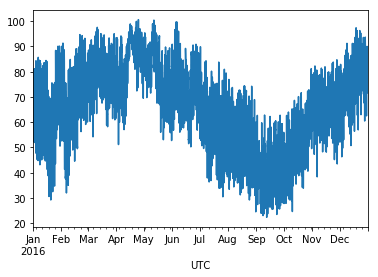

In [75]:
hydro_v2[hydro_v2.columns[0]].plot()

In [76]:
hydro_v2_factor = hydro_v2.copy()
for plantid in hydro_v2.columns:
    cap = plant.loc[plantid]['GenMWMax']
    hydro_v2_factor[plantid] = hydro_v2_factor[plantid].apply(lambda x: x/cap)

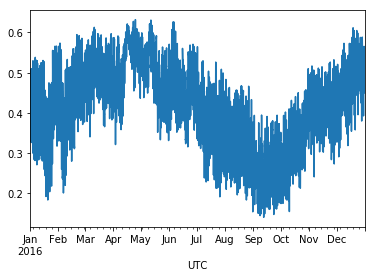

In [77]:
hydro_v2_factor[hydro_v2_factor.columns[0]].plot()

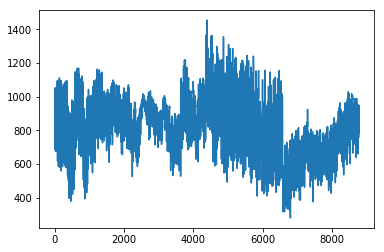

In [78]:
from matplotlib import pyplot as plt
plt.plot(hydro_v2_az_total)
plt.show()

In [79]:
hydro_v2_factor.apply(lambda x: x>1).sum().sum()

10800

In [81]:
hydro_v2_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Columns: 715 entries, 10390 to 12863
dtypes: float64(715)
memory usage: 48.0 MB


## Change capacity reference from TAMU network to 2016 western hydro capacity for each state from scenario design document

In [82]:
from collections import defaultdict
total_hydro_capacity = defaultdict(float)
for plantid in hydro_v2.columns:
    state = plant.loc[plantid]['zone_name']
    if state in {'Northern California','Bay Area','Central California','Southwest California','Southeast California'}:
        total_hydro_capacity['California'] += plant.loc[plantid]['GenMWMax']
    else:
        total_hydro_capacity[state] += plant.loc[plantid]['GenMWMax']
eia_cap = {
    'Arizona':2912,
    'California':13801,
    'Colorado':1178,
    'Idaho':2543,
    'Montana Western':2665,
    'Nevada':1052,
    'New Mexico Western':82,
    'Oregon':8451,
    'Utah':262,
    'Washington':21437,
    'Wyoming':303
}
scale_f = {}
for state in eia_cap:
    f = eia_cap[state]/total_hydro_capacity[state]
    if state == 'California':
        scale_f['Northern California'] = f
        scale_f['Bay Area'] = f
        scale_f['Central California'] = f
        scale_f['Southwest California'] = f
        scale_f['Southeast California'] = f
    else:
        scale_f[state] = f
scale_f

{'Arizona': 1.0082404099794096,
 'Northern California': 1.0635106094975635,
 'Bay Area': 1.0635106094975635,
 'Central California': 1.0635106094975635,
 'Southwest California': 1.0635106094975635,
 'Southeast California': 1.0635106094975635,
 'Colorado': 1.1004203614066421,
 'Idaho': 1.0930128250977846,
 'Montana Western': 1.0375274845681384,
 'Nevada': 1.0121223966017905,
 'New Mexico Western': 1.2443095281423788,
 'Oregon': 1.018155980123368,
 'Utah': 1.44114414675395,
 'Washington': 1.012717518709653,
 'Wyoming': 1.1707882537671188}

In [83]:
total_hydro_capacity

defaultdict(float,
            {'Washington': 21167.798131224,
             'Oregon': 8300.299919641006,
             'California': 12976.833401333002,
             'Nevada': 1039.3999812,
             'Arizona': 2888.2000475060004,
             'Utah': 181.79999592,
             'New Mexico Western': 65.90000168399999,
             'Colorado': 1070.50000283,
             'Wyoming': 258.79999993600006,
             'Idaho': 2326.5966707870007,
             'Montana Western': 2568.606653451})

In [84]:
hydro_v2_factor_scale = hydro_v2.copy()
cnt = 0
for plantid in hydro_v2.columns:
    cap = plant.loc[plantid]['GenMWMax']*scale_f[plant.loc[plantid]['zone_name']]
    hydro_v2_factor_scale[plantid] = hydro_v2_factor_scale[plantid].apply(lambda x: x/cap)
    for index, val in hydro_v2_factor_scale[plantid].items():
        if val > 1:
            cnt += 1
            print(cnt,index,plant.loc[plantid]['zone_name'],hydro_v2[plantid][index],cap,val)

In [321]:
hydro_v2_factor_scale.to_csv('western_hydro_v2_factor_reference.csv')

## Check the generation output percentage factor with the 2016 reference rather than the capacities in TAMU network

In [85]:
hydro_v2_factor_scale.apply(lambda x: x>1).sum().sum()

0

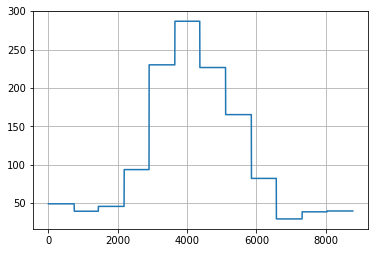

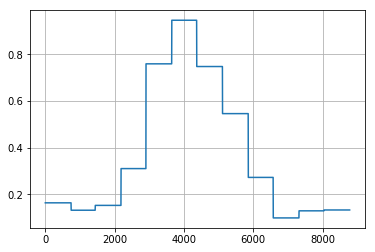

In [86]:
from matplotlib import pyplot as plt
plt.plot(hydro_v2_wy_total)
plt.grid()
plt.show()
hydro_v2_wy_total_normalize = [val/303 for val in hydro_v2_wy_total]
plt.plot(hydro_v2_wy_total_normalize)
plt.grid()
plt.show()

## Generate the final hydro v2 profile, which uses capacities in TAMU network as references. In this way, after we apply the change table function when creating the WECC basecase scenario, this hydro profile will be scaled back to the profile we generated above: western_hydro_v2_reference.csv

In [87]:
hydro_v2_tamu_cap = hydro_v2.copy()
for plantid in hydro_v2.columns:
    factor = scale_f[plant.loc[plantid]['zone_name']]
    hydro_v2_tamu_cap[plantid] = hydro_v2_tamu_cap[plantid].apply(lambda x: x/factor)

In [324]:
hydro_v2_tamu_cap.to_csv('western_hydro_v2.csv')

# Generate hydro profile v2 for Texas based on the data profile from ERCOT

In [88]:
filename = 'texas_hydro_gmt.csv'
filedir = './'
ercot_hydro_profile = pd.read_csv(filedir+filename,header = 0,index_col = 'DateTimeUTC')
ercot_hydro_profile = list(ercot_hydro_profile.dropna()['sum_hydro'])

In [89]:
Texas = Grid(['Texas'])
plant_tx = Texas.plant

--> Loading Texas interconnect
Loading zone
Loading sub
Loading bus2sub
Loading bus
Loading plant
Loading plant cost
Loading branch
Loading DC line


In [90]:
texas_hydro_v2 = pd.DataFrame(index = hydro_v2.index, columns = plant_tx[plant_tx['type']=='hydro'].index)
total_hydro_cap_tx = plant_tx[plant_tx['type']=='hydro']['GenMWMax'].sum()
for plantid in texas_hydro_v2.columns:
    plant_cap = plant_tx.loc[plantid]['GenMWMax']
    texas_hydro_v2[plantid] = [tot*plant_cap/total_hydro_cap_tx for tot in ercot_hydro_profile]

In [96]:
texas_hydro_v2.to_csv('texas_hydro_v2_reference.csv')

## Generate the final hydro v2 profile for Texas, which uses capacities in TAMU network as references. In this way, after we apply the change table function when creating the WECC-Texas basecase scenario, this hydro profile will be scaled back to the profile we generated above: texas_hydro_v2_reference.csv

In [92]:
from collections import defaultdict
total_hydro_capacity_tx = defaultdict(float)
for plantid in texas_hydro_v2.columns:
    zone = plant_tx.loc[plantid]['zone_name']
    total_hydro_capacity_tx[zone] += plant_tx.loc[plantid]['GenMWMax']

eia_cap_tx = {
    'Coast':0,
    'East':0,
    'Far West':0,
    'North':80,
    'North Central':52,
    'South':46,
    'South Central':239,
    'West':139,
}
# scale_f_tx = {}
# for zone in eia_cap_tx:
#     f = eia_cap_tx[zone]/total_hydro_capacity_tx[zone]
#     scale_f_tx[zone] = f
# scale_f

In [93]:
total_hydro_capacity_tx

defaultdict(float,
            {'West': 138.8,
             'South': 45.6,
             'North Central': 51.6,
             'South Central': 239.1,
             'North': 80.0})

## Revised Texas total hydro capacity for each loadzone matches EIA cap. No need to scale back, i.e. texas_hydro_v2 = texas_hydro_v2_tamu_cap, texas_hydro_v2_reference.csv is the final input profile.

In [94]:
texas_hydro_v2.sum().sum()

1060477.7772759995

In [95]:
sum(ercot_hydro_profile)

1060477.777275999